#### iLQR for kinematic example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
from ocp import *
from costs import *
from ocp_utils import *

import pybullet as p
import pybullet_data

%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=4, suppress=True)

#### Setup pybullet with the urdf

In [2]:
# configure pybullet and load plane.urdf and quadcopter.urdf
#physicsClient = p.connect(p.DIRECT)  # pybullet only for computations no visualisation, faster
physicsClient = p.connect(p.GUI)  # pybullet with visualisation
p.configureDebugVisualizer(p.COV_ENABLE_GUI,0)

p.setAdditionalSearchPath(pybullet_data.getDataPath())

In [3]:
p.resetSimulation()

robot_urdf = "../data/urdf/frankaemika_new/panda_arm.urdf"
robot_id = p.loadURDF(robot_urdf, useFixedBase=1)
joint_limits = get_joint_limits(robot_id, 7)

p.loadURDF('plane.urdf')

#Define the end-effector
link_id = 10
link_name = 'panda_grasptarget_hand'

#Create a ball to show the target
_,_,ballId = create_primitives(radius=0.05)

#### Finding the joint (and link) index 

In [4]:
for i in range(p.getNumJoints(robot_id)):
    print(i, p.getJointInfo(robot_id, i)[1])

0 b'panda_joint1'
1 b'panda_joint2'
2 b'panda_joint3'
3 b'panda_joint4'
4 b'panda_joint5'
5 b'panda_joint6'
6 b'panda_joint7'
7 b'panda_hand_joint'
8 b'panda_finger_joint1'
9 b'panda_finger_joint2'
10 b'panda_grasptarget_hand'


### Construct the robot system

In [5]:
dt = 0.05
T = 100
dof = 7
sys = URDFRobot(dof=dof, robot_id=robot_id, dt = dt)

#### Find a random target orientation 

In [19]:
qT = np.random.uniform(-1,1,7)
qT[3] -= 1.5
qT[5] += 1.5
xT = np.concatenate([qT, np.zeros(7)])
sys.set_init_state(xT)
_,o_target = sys.compute_ee(xT,link_id)
print("Target orientation: ",o_target)

Target orientation:  [ 0.4852 -0.4149  0.7585  0.1311]


#### Set the initial state

In [20]:
q0 = np.random.rand(7)
q0 = np.array([0.,0.,0.,-1.5,0.,1.5,0.])
#q0 = np.array([0.4201, 0.4719, 0.9226, 0.8089, 0.3113, 0.7598, 0.364 ])
x0 = np.concatenate([q0, np.zeros(7)])
sys.set_init_state(x0)
_,o_0 = sys.compute_ee(x0,link_id)
print("X0 orientation: ",o_0)

X0 orientation:  [ 0.9239  0.3827 -0.      0.    ]


#### Try forward kinematics

In [21]:
pos0, quat0 = sys.compute_ee(x0, link_id)

#Put the ball at the end-effector
p.resetBasePositionAndOrientation(ballId, pos0, quat0)
print(pos0, quat0)

[ 0.5477 -0.      0.5465] [ 0.9239  0.3827 -0.      0.    ]


#### Set initial control output

In [22]:
#set initial control output to be all zeros
us = np.zeros((T+1,sys.Du))
_ = sys.compute_matrices(x0, us[0])
xs = sys.rollout(us[:-1])

#### Plot initial trajectory

#### Set the regularization cost coefficients Q and R 

In [23]:
Q = np.eye(sys.Dx)*1
Q[0:sys.dof,0:sys.dof] *= 0.01  #only put cost regularization on the velocity, not on the joint angles
Qf = np.eye(sys.Dx)*1
Qf[0:sys.dof,0:sys.dof] *= 0.01 #only put cost regularization on the velocity, not on the joint angles
R = np.eye(sys.Du)*1e-9
mu = 1e-9          #regularization coefficient

#### Set the task space cost coefficients W & WT

In [24]:
W = np.diag([1,1,1])
WT = np.diag([1,1,1])

### iLQR using cost model

#### Define the cost

In [25]:
#The costs consist of: a) state regularization (Q), b) control regularization (R), and c) End-effector reaching task (W)
#Running cost is for the time 0 <= t < T, while terminal cost is for the time t = T
runningStateCost = CostModelQuadratic(sys, Q)
runningControlCost = CostModelQuadratic(sys, None, R)
runningEECost = CostModelQuadraticOrientation(sys,W, link_id,o_target)
runningCost = CostModelSum(sys, [runningStateCost, runningControlCost, runningEECost])

terminalStateCost = CostModelQuadratic(sys,Qf)
terminalControlCost = CostModelQuadratic(sys, None,R)
terminalEECost = CostModelQuadraticOrientation(sys,WT, link_id,o_target)
terminalCost = CostModelSum(sys, [terminalStateCost, terminalControlCost, terminalEECost])

costs = [runningCost]*T + [terminalCost]

#### Construct ILQR

In [26]:
ilqr_cost = ILQR(sys, mu)
ilqr_cost.set_init_state(x0)
ilqr_cost.set_timestep(T)
ilqr_cost.set_cost(costs)
ilqr_cost.set_state(xs, us) #set initial trajectory

In [27]:
ilqr_cost.mu = mu

#### Solve and Plot

In [28]:
n_iter = 30
ilqr_cost.solve(n_iter, method='recursive')
xs_batch, us_batch = ilqr_cost.xs, ilqr_cost.us

#clear_output()

Cost converges at iteration 7, cannot decrease further


#### Play traj

In [29]:
sys.vis_traj(ilqr_cost.xs)

#### Compute Error

In [30]:
pos, quat = sys.compute_ee(ilqr_cost.xs[-1], link_id)

print(quat)
print(o_target)

[ 0.4906 -0.4104  0.7569  0.1344]
[ 0.4852 -0.4149  0.7585  0.1311]


### Check the two frames visually

In [17]:
from mpl_toolkits.mplot3d import Axes3D
desired_orn_mat = quat2Mat(o_target)
obtained_orn_mat = quat2Mat(quat)

desired_frame = np.identity(4)
desired_frame[:3,:3] = desired_orn_mat

obtained_frame = np.identity(4)
obtained_frame[:3,:3] = obtained_orn_mat

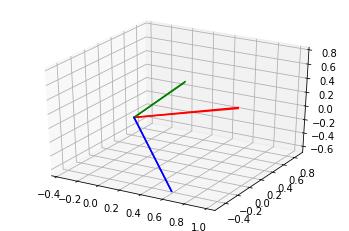

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot_pose_matrix(ax,desired_frame,'')
plot_pose_matrix(ax,obtained_frame,'')
set_axes_equal(ax)
plt.show()

## Check the orientation derivative

Validate the derivative calculation of the orientation cost using numerical differentiation. This is a good practice when creating a new cost function, to check if our analytical calculation is correct. 

In [19]:
idx = np.random.randint(len(ilqr_cost.xs))
x = ilqr_cost.xs[idx]
u = ilqr_cost.us[idx]

In [20]:
inc = 0.001
J = np.zeros((1, len(x)))
for i in range(len(xs[0])):
    x_p = x.copy()
    x_p[i] += inc
    cost_p = runningEECost.calc(x_p, u)
    
    x_m = x.copy()
    x_m[i] -= inc
    cost_m = runningEECost.calc(x_m, u)
    
    diff = (cost_p-cost_m)/(2*inc)
    J[0,i] = diff
    
J_true = runningEECost.calcDiff(x, u)
J_true = runningEECost.Lx
print(J)
print(J_true)
print(J-J_true)

[[ 0.0007  0.0055 -0.0064 -0.0009  0.0264 -0.01    0.0159  0.      0.
   0.      0.      0.      0.      0.    ]]
[ 0.0007  0.0055 -0.0064 -0.0009  0.0264 -0.01    0.0159  0.      0.
  0.      0.      0.      0.      0.    ]
[[ 0. -0. -0.  0. -0.  0. -0.  0.  0.  0.  0.  0.  0.  0.]]
